In [2]:
import pandas as pd
from game.poker_oracle import PokerOracle
import utils.config as config
import numpy as np
from itertools import combinations

In [ ]:
oracle = PokerOracle()

In [ ]:
pub_cards = ("9♣", "9♦", "T♣")

In [ ]:
matrix = PokerOracle.calculate_utility_matrix(pub_cards)

In [ ]:
matrix[0, -1]

In [ ]:
matrix.tofile("matrix.csv", sep=",")

In [ ]:
matrix_width, matrix_height = matrix.shape

for i in range(matrix_width):
    for j in range(matrix_height):
        if not matrix[i, j] == -matrix[j, i]:
            print(f"{matrix[i, j]} - {matrix[j, i]}")

In [ ]:
print(np.all(matrix == -matrix.T), np.sum(matrix) == 0)

In [ ]:
matrix.shape

In [ ]:
l = matrix.tofile("matrix.csv", sep=",", format="%10.5f")

In [ ]:
PokerOracle.quantify_hand(["9♣", "T♥"], ["K♣", "A♦", "A♣"], oracle)

In [ ]:
deck = PokerOracle.generate_deck()
deck

In [ ]:
all_hole_cards = list(combinations(deck, 2)) == list(PokerOracle.all_hole_combinations())
all_hole_cards

In [ ]:
all_hole_cards = list(PokerOracle.all_hole_combinations())

In [ ]:
range = np.ones(len(all_hole_cards))
print(len(range), range)

In [ ]:
def cards_to_range_index(card1, card2):
    return all_hole_cards.index((card1, card2))

def range_index_to_cards(index):
    return all_hole_cards[index]

def cards_to_range_index_both_ways(card1, card2):
    return cards_to_range_index(card1, card2), cards_to_range_index(card2, card1)

In [ ]:
card1 = '9♠'
for card2 in deck:
    if card1 == card2:
        continue 
    index  = cards_to_range_index(card1, card2)
    print(f'{card1} {card2} {index} -- {range_index_to_cards(index)}')

In [ ]:
all_hole_cards

# Data gen

In [9]:
import data.datagen as datagen
from state.state_manager import PokerGameStage
import multiprocessing as mp

In [10]:
def generate_data(start, end, stage, n_pub):
    local_data = []
    for i in range(start, end):
        if i % 10 == 0:
            print(i)
        local_data.append(datagen.get_random_example((stage, n_pub)))
    return local_data

In [11]:
def get_data_mp(stage, n_pub):
    num_processes = 8
    total_items = 1000

    pool = mp.Pool(processes=num_processes)

    # Calculate the chunk size for each process
    chunk_size = total_items // num_processes
    ranges = [(i * chunk_size, (i + 1) * chunk_size) for i in range(num_processes)]
    ranges[-1] = (ranges[-1][0], total_items)  # Ensure the last range covers the remainder

    # Map the generate_data function to the data ranges
    results = [pool.apply_async(generate_data, args=(r[0], r[1], stage, n_pub)) for r in ranges]

    # Close the pool and wait for the work to finish
    pool.close()
    pool.join()

    # Collect all results from the processes
    data = []
    for result in results:
        data.extend(result.get())

    return data

In [12]:
n_pub = 4
stage = PokerGameStage.TURN
new_data = get_data_mp(stage, n_pub)

Process SpawnPoolWorker-1:
Process SpawnPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Process SpawnPoolWorker-3:
Traceback (most recent call last):
  File "/opt/miniconda3/envs/recsys/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/miniconda3/envs/recsys/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/miniconda3/envs/recsys/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/miniconda3/envs/recsys/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'generate_data' on <module '__main__' (built-in)>
  File "/opt/miniconda3/envs/recsys/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/miniconda3/envs/recsys/lib/pyth

KeyboardInterrupt: 

In [ ]:
data = []
for i in range(1000):
    if i % 10 == 0:
        print(i)
    data.append(datagen.get_random_example((stage, n_pub)))

In [1]:
import pickle as pkl
import torch
test_frac = 0.2
size = 1000
test_num = int(size * test_frac)

In [6]:
pkl.dump(data, open("data.pkl", "wb"))

In [18]:
dataset = torch.cat(data)

In [22]:
train_dataset, test_dataset = dataset.split([size - test_num, test_num])

In [24]:
print(train_dataset.shape, test_dataset.shape)

torch.Size([800, 1111]) torch.Size([200, 1111])


In [25]:
torch.save(train_dataset, "train_dataset.pt")
torch.save(test_dataset, "test_dataset.pt")

# Model training

In [1]:
import torch
d = torch.load("data/RIVER/train1.pt")
import pandas as pd
import numpy as np
from game.poker_oracle import PokerOracle

In [12]:
pot_index = 276*2+5

In [13]:
invecs, cards, pot, p1, p2, _ = d.split([
    276 * 2,
    5,
    1,
    276,
    276,
    1], dim=1)

In [14]:
torch.mean(d[:, pot_index])

tensor(19.4296, dtype=torch.float64)

In [15]:
def public_cards_to_index(cards_col):
    
    idx = []
    deck = PokerOracle.generate_deck()
    for cards in cards_col:
        cards = cards.replace('clubs', '♣')
        cards = cards.replace('hearts', '♥')
        cards = cards.replace('diamonds', '♦')
        cards = cards.replace('spades', '♠')
        cards = cards.replace('10', 'T')
        idx.append(deck.index(cards))

    return idx

In [40]:
public_cards_to_index(df['public_cards'][0])

10clubs
Kspades
9hearts
10hearts
Jdiamonds


[7, 16, 1, 5, 10]

In [43]:
df['public_cards'] = df['public_cards'].apply(public_cards_to_index)

10clubs
Kspades
9hearts
10hearts
Jdiamonds
Qclubs
Khearts
9spades
Qspades
10spades
Khearts
Qclubs
Aspades
10hearts
Ahearts
Qspades
Ahearts
Qdiamonds
9hearts
9spades
Qclubs
9hearts
Ahearts
Kspades
Khearts
Qclubs
Qhearts
Khearts
Kspades
10clubs
10diamonds
Khearts
9diamonds
Jclubs
10clubs
Khearts
Aspades
9clubs
Qdiamonds
10diamonds
Kclubs
Qdiamonds
Aspades
10spades
10diamonds
9hearts
Kclubs
Qclubs
Aclubs
Kdiamonds
10hearts
Aspades
9hearts
Qdiamonds
Kdiamonds
Jspades
Qhearts
10spades
Qdiamonds
10clubs
Qdiamonds
Jhearts
Kspades
10diamonds
10clubs
10hearts
Kclubs
Qspades
Ahearts
Jspades
Kdiamonds
9hearts
Jspades
Jdiamonds
10hearts
Jhearts
Jspades
Ahearts
Adiamonds
9spades
Jdiamonds
Adiamonds
10spades
Aclubs
Ahearts
10clubs
Adiamonds
Qspades
Kdiamonds
9hearts
Kspades
10diamonds
Kclubs
Qdiamonds
Khearts
Khearts
10spades
10diamonds
10clubs
Kspades
9diamonds
Jdiamonds
Kdiamonds
Qhearts
10diamonds
10diamonds
Jclubs
9clubs
10spades
Qclubs
Jhearts
Kclubs
Adiamonds
Qclubs
Aspades
Jdiamonds
Jclubs
Jh

In [46]:
df

,case_id,r1,r2,public_cards,pot,v1,v2
0,0,<generator object parse_array.<locals>.<genexp...,<generator object parse_array.<locals>.<genexp...,"[7, 16, 1, 5, 10]",72,<generator object parse_array.<locals>.<genexp...,<generator object parse_array.<locals>.<genexp...
1,1,<generator object parse_array.<locals>.<genexp...,<generator object parse_array.<locals>.<genexp...,"[15, 17, 0, 12, 4]",60,<generator object parse_array.<locals>.<genexp...,<generator object parse_array.<locals>.<genexp...
2,2,<generator object parse_array.<locals>.<genexp...,<generator object parse_array.<locals>.<genexp...,"[17, 15, 20, 5, 21]",100,<generator object parse_array.<locals>.<genexp...,<generator object parse_array.<locals>.<genexp...
3,3,<generator object parse_array.<locals>.<genexp...,<generator object parse_array.<locals>.<genexp...,"[12, 21, 14, 1, 0]",64,<generator object parse_array.<locals>.<genexp...,<generator object parse_array.<locals>.<genexp...
4,4,<generator object parse_array.<locals>.<genexp...,<generator object parse_array.<locals>.<genexp...,"[15, 1, 21, 16, 17]",16,<generator object parse_array.<locals>.<genexp...,<generator object parse_array.<locals>.<genexp...
...,...,...,...,...,...,...,...
4995,4995,<generator object parse_array.<locals>.<genexp...,<generator object parse_array.<locals>.<genexp...,"[22, 6, 18, 0, 20]",32,<generator object parse_array.<locals>.<genexp...,<generator object parse_array.<locals>.<genexp...
4996,4996,<generator object parse_array.<locals>.<genexp...,<generator object parse_array.<locals>.<genexp...,"[13, 10, 21, 16, 18]",140,<generator object parse_array.<locals>.<genexp...,<generator object parse_array.<locals>.<genexp...
4997,4997,<generator object parse_array.<locals>.<genexp...,<generator object parse_array.<locals>.<genexp...,"[3, 2, 21, 7, 9]",60,<generator object parse_array.<locals>.<genexp...,<generator object parse_array.<locals>.<genexp...
4998,4998,<generator object parse_array.<locals>.<genexp...,<generator object parse_array.<locals>.<genexp...,"[10, 9, 13, 22, 19]",100,<generator object parse_array.<locals>.<genexp...,<generator object parse_array.<locals>.<genexp...


In [25]:
df = pd.read_csv("turn.csv")
def parse_vector(vector_str):
    return np.array(list(map(float, vector_str.split(','))))

def parse_array(s):
    return np.array([float(item) for item in s.strip('[]').split(',')])

def parse_cards(s):
    return s.strip('[]').replace("'", "").split(', ')

def public_cards_to_index(cards_col):
    idx = []
    deck = PokerOracle.generate_deck()
    for cards in cards_col:
        cards = cards.replace('clubs', '♣')
        cards = cards.replace('hearts', '♥')
        cards = cards.replace('diamonds', '♦')
        cards = cards.replace('spades', '♠')
        cards = cards.replace('10', 'T')
        idx.append(deck.index(cards))

    return idx


df['r1'] = df['r1'].apply(parse_array)
df['r2'] = df['r2'].apply(parse_array)
df['v1'] = df['v1'].apply(parse_array)
df['v2'] = df['v2'].apply(parse_array)
df['public_cards'] = df['public_cards'].apply(parse_cards)
df['public_cards'] = df['public_cards'].apply(public_cards_to_index)

In [26]:
print(df['r1'].tolist()[0])  # Print first element to check its structure


[1.17200222e-03 8.29122285e-03 9.13283750e-03 3.71588260e-03
 5.14392111e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.16041026e-03 6.35888357e-03 3.18341497e-03 6.36973474e-03
 6.95295337e-03 2.99029971e-04 9.01400641e-03 1.63729150e-03
 9.42839208e-03 1.36894289e-03 2.62056076e-03 9.14823362e-03
 0.00000000e+00 6.80077130e-03 8.44868147e-03 9.31479499e-03
 5.07753089e-03 4.48762252e-04 7.77845259e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.43631284e-03 7.74405344e-03
 2.17340573e-03 2.97842233e-03 6.68772148e-03 8.85955818e-03
 3.22664963e-03 6.05685271e-03 4.94926680e-04 7.66406795e-03
 6.90380303e-03 4.94540612e-03 0.00000000e+00 2.59017891e-03
 7.65453244e-03 7.73041793e-03 6.17185048e-03 5.08683270e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.62427920e-03
 9.16774917e-03 5.01470827e-03 4.66925135e-04 3.79318770e-03
 4.90658566e-03 1.11320439e-03 9.20998428e-05 4.22851553e-04
 9.10442884e-04 2.85529490e-03 4.62003209e-03 0.00000000e+00
 8.98440603e-03 5.972475

In [27]:
def df_to_tensor(df):
    tensors = []
    
    # Add `r1` and `r2` first
    tensors.append(torch.tensor(df['r1'].tolist(), dtype=torch.float))
    tensors.append(torch.tensor(df['r2'].tolist(), dtype=torch.float))

    # Add `public_cards` indices as tensors (convert to long if using as indices)
    tensors.append(torch.tensor(df['public_cards'].tolist(), dtype=torch.long))

    # Add `pot`
    tensors.append(torch.tensor(df['pot'].values, dtype=torch.float).view(-1, 1))

    # Add `v1` and `v2`
    tensors.append(torch.tensor(df['v1'].tolist(), dtype=torch.float))
    tensors.append(torch.tensor(df['v2'].tolist(), dtype=torch.float))

    # Concatenate all tensors along columns
    full_tensor = torch.cat(tensors, dim=1)
    return full_tensor

# Convert the DataFrame to a tensor with the correct order
data_tensor = df_to_tensor(df)


In [28]:
data_tensor.shape

torch.Size([1803, 1109])

In [29]:
torch.save(data_tensor, "data_tensor.pt")

In [57]:
d.shape

torch.Size([2400, 1111])

In [23]:
# get sum and std dev of pot
pot_sum = torch.mean(pot)
pot_std = torch.std(pot)
print(pot_sum, pot_std)

NameError: name 'pot' is not defined

In [24]:
from nn.nn_training import NNTrainer
from state.state_manager import PokerGameStage
stage = PokerGameStage.FLOP

In [25]:
trainer = NNTrainer()

In [26]:
trainer.train_network(stage, 150, 5000)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs/FLOP/lightning_logs

  | Name         | Type   | Params
----------------------------------------
0 | fc1          | Linear | 779 K 
1 | fc2          | Linear | 1.4 M 
2 | fc3          | Linear | 700 K 
3 | value_output | Linear | 386 K 
----------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.074    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


In [15]:
import matplotlib.pyplot as plt
import pandas as pd

In [27]:
df = pd.read_csv("lightning_logs/FLOP/lightning_logs/version_0/metrics.csv")
df_train_loss = df[df["train_loss"].notnull()]
df_val_loss = df[df["val_loss"].notnull()]
df_accum_train_loss = df_train_loss.groupby('epoch').mean()
df_accum_val_loss = df_val_loss.groupby('epoch').mean()

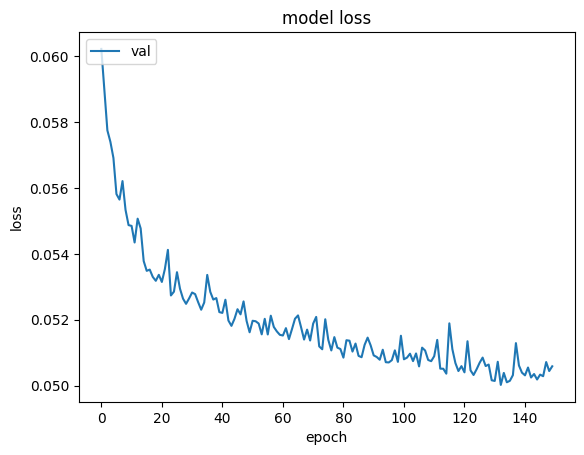

In [28]:
# Val loss
plt.plot(df_accum_val_loss['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val'], loc='upper left')
plt.show()

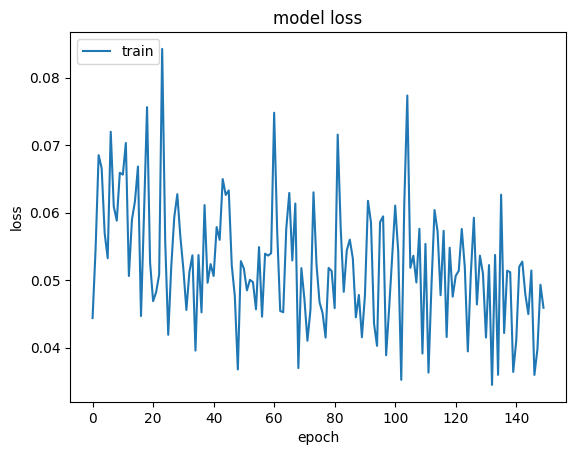

In [30]:
# Val loss
plt.plot(df_accum_train_loss['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()